In [1]:
import matplotlib.pyplot as plt
import time
import torch
from torch import logsumexp
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import numpy as np

In [2]:
iterations = 10000

num_samples = 100
p_mu = 0.0
# q_sigma = torch.tensor([1.0])

lr = 5*1e-3

log_Z = np.log(np.sqrt((2*np.pi)))

In [3]:
def rws(num_samples, q_mu, q_sigma, lr):
    EUBO = []
    ELBO = []
    Mu = []
    Sigma = []
    Grad_mu = []
    Grad_sigma = []
    ESS = []
    
    for i in range(iterations):
        optimizer.zero_grad()
        proposal = Normal(q_mu, q_sigma)
        xs = proposal.sample((num_samples,))
        log_gammas = (-1.0 / 2.0) * ((xs - p_mu) ** 2)
        log_q = proposal.log_prob(xs)
        log_weights = log_gammas - log_q
        weights = torch.exp(log_weights - logsumexp(log_weights, dim=0)).detach()
        ess = 1. / (weights ** 2).sum()
        eubo = torch.mul(weights, log_weights).sum()
        elbo = log_weights.mean()
        grads = torch.autograd.grad(eubo, [q_mu, q_sigma])
        q_mu = q_mu - lr * grads[0]
        q_sigma =  q_sigma - lr * grads[1]
        EUBO.append(eubo.item())
        ELBO.append(elbo.item())
        Mu.append(q_mu.item())
        Sigma.append(q_sigma.item())
        Grad_mu.append(grads[0].item())
        Grad_sigma.append(grads[1].item())
        ESS.append(ess.item())
    return EUBO, ELBO, Mu, Sigma, Grad_mu, Grad_sigma, ESS

In [4]:
def train(mu, init_sigmas, num_samples, lr):
    num_sigmas = init_sigmas.shape[0]
    EUBOs = []
    ELBOs = []
    Grad_mus = []
    Grad_sigmas = []
    Mus = []
    Sigmas = []
    ESSs = []
    for j in range(num_sigmas):
        time_start = time.time()
        q_mu = torch.tensor([1.0], requires_grad=True) * mu
        q_sigma = torch.tensor([1.0], requires_grad=True) * init_sigmas[j]
        EUBO, ELBO, Mu, Sigma, Grad_mu, Grad_sigma, ESS = rws(num_samples, q_mu, q_sigma, lr)
        EUBOs.append(EUBO)
        ELBOs.append(ELBO)
        Grad_mus.append(Grad_mu)
        Grad_sigmas.append(Grad_sigma)
        Mus.append(Mu)
        Sigmas.append(Sigma)
        ESSs.append(ESS)
        time_end = time.time()
        print('init_mu=%d, init_sigma=%d, samples : %d (%ds)' % (mu, init_sigmas[j], num_samples, time_end - time_start))    
    return EUBOs, ELBOs, Mus, Sigmas, Grad_mus, Grad_sigmas, ESSs

In [5]:
def plot_results(EUBOs, ELBOs, Mus, Sigmas, Grad_mus, Grad_sigmas, ESSs, mu, init_sigmas, num_samples):
    num_sigmas = init_sigmas.shape[0]
    fig = plt.figure(figsize=(20, 20))
    for j in range(num_sigmas):
#         fig.subplots_adjust(bottom=0.1, right=0.1, top=0.9)
        fig.tight_layout()
        ax1 = fig.add_subplot(num_sigmas, 3, j*3 + 1)
        ax2 = fig.add_subplot(num_sigmas, 3, j*3 + 2)
        ax3 = fig.add_subplot(num_sigmas, 3, j*3 + 3)
        ax1.plot(EUBOs[j], 'r', label='EUBOs')
        ax1.plot(ELBOs[j], 'b', label='ELBOs')
        ax1.plot(np.ones(iterations) * log_Z, 'k', label='log_Z')
        ax1.set_ylim([-50, 20])
        ax1.tick_params(labelsize=14)
        
        ax2.plot(Mus[j], 'm', label='mu')
        ax2.plot(Sigmas[j], 'gray', label='sigma')
        ax2.tick_params(labelsize=14)
        ax2.plot(Grad_mus[j], 'g', label='grad mu')
        ax2.plot(Grad_sigmas[j], 'orange', label='grad sigma')
        ax3.plot(ESSs[j], label='ESS')
        ax3.tick_params(labelsize=14)

        ax1.set_title('mu=%d, sigma=%d, samples=%d' % (mu, init_sigmas[j], num_samples), fontsize=14)
        if j == 0:
            ax1.legend()
            ax2.legend()
            ax3.legend()
    plt.savefig('univariate_gaussian_rws_learn_both_mu=%d_samples=%d.svg' % (mu, num_samples))

init_mu=6, init_sigma=1, samples : 100 (0s)
init_mu=6, init_sigma=2, samples : 100 (0s)
init_mu=6, init_sigma=4, samples : 100 (0s)
init_mu=6, init_sigma=6, samples : 100 (0s)
init_mu=8, init_sigma=1, samples : 100 (0s)
init_mu=8, init_sigma=2, samples : 100 (0s)
init_mu=8, init_sigma=4, samples : 100 (0s)
init_mu=8, init_sigma=6, samples : 100 (0s)


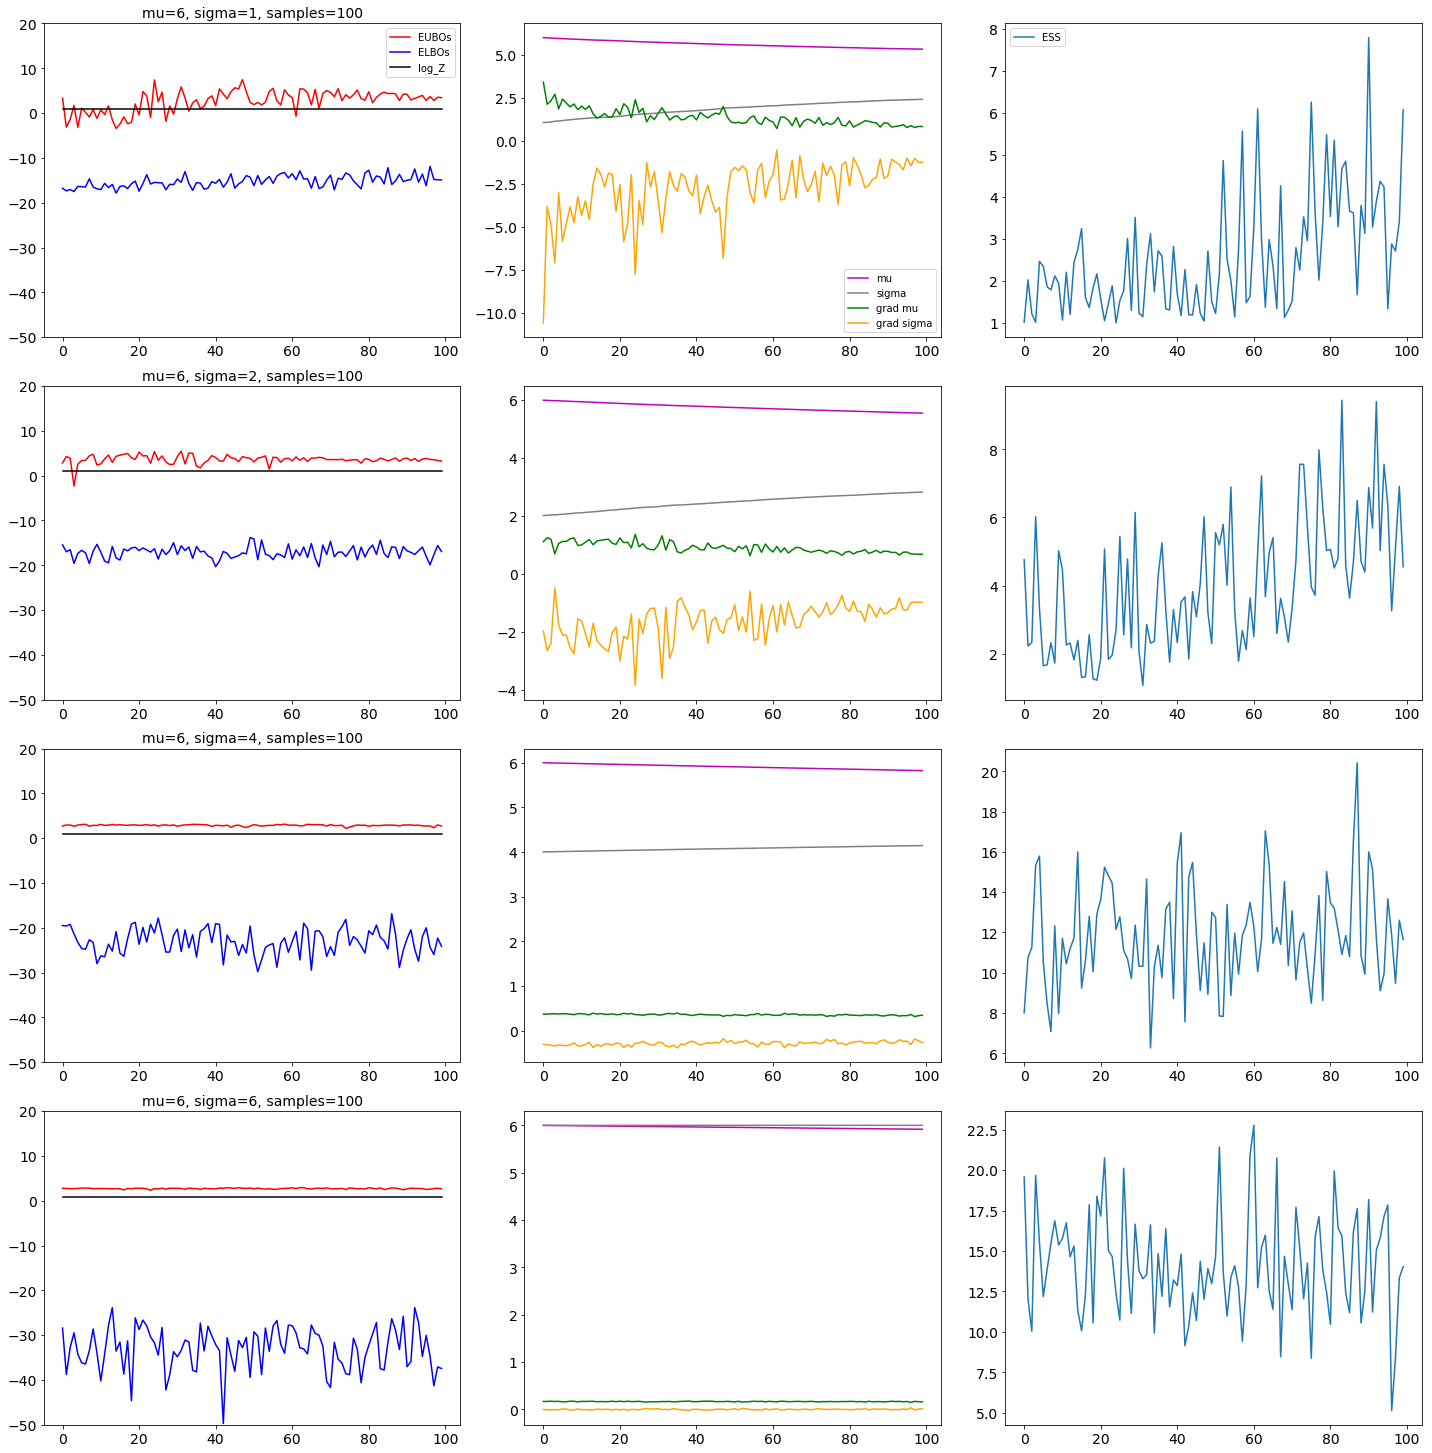

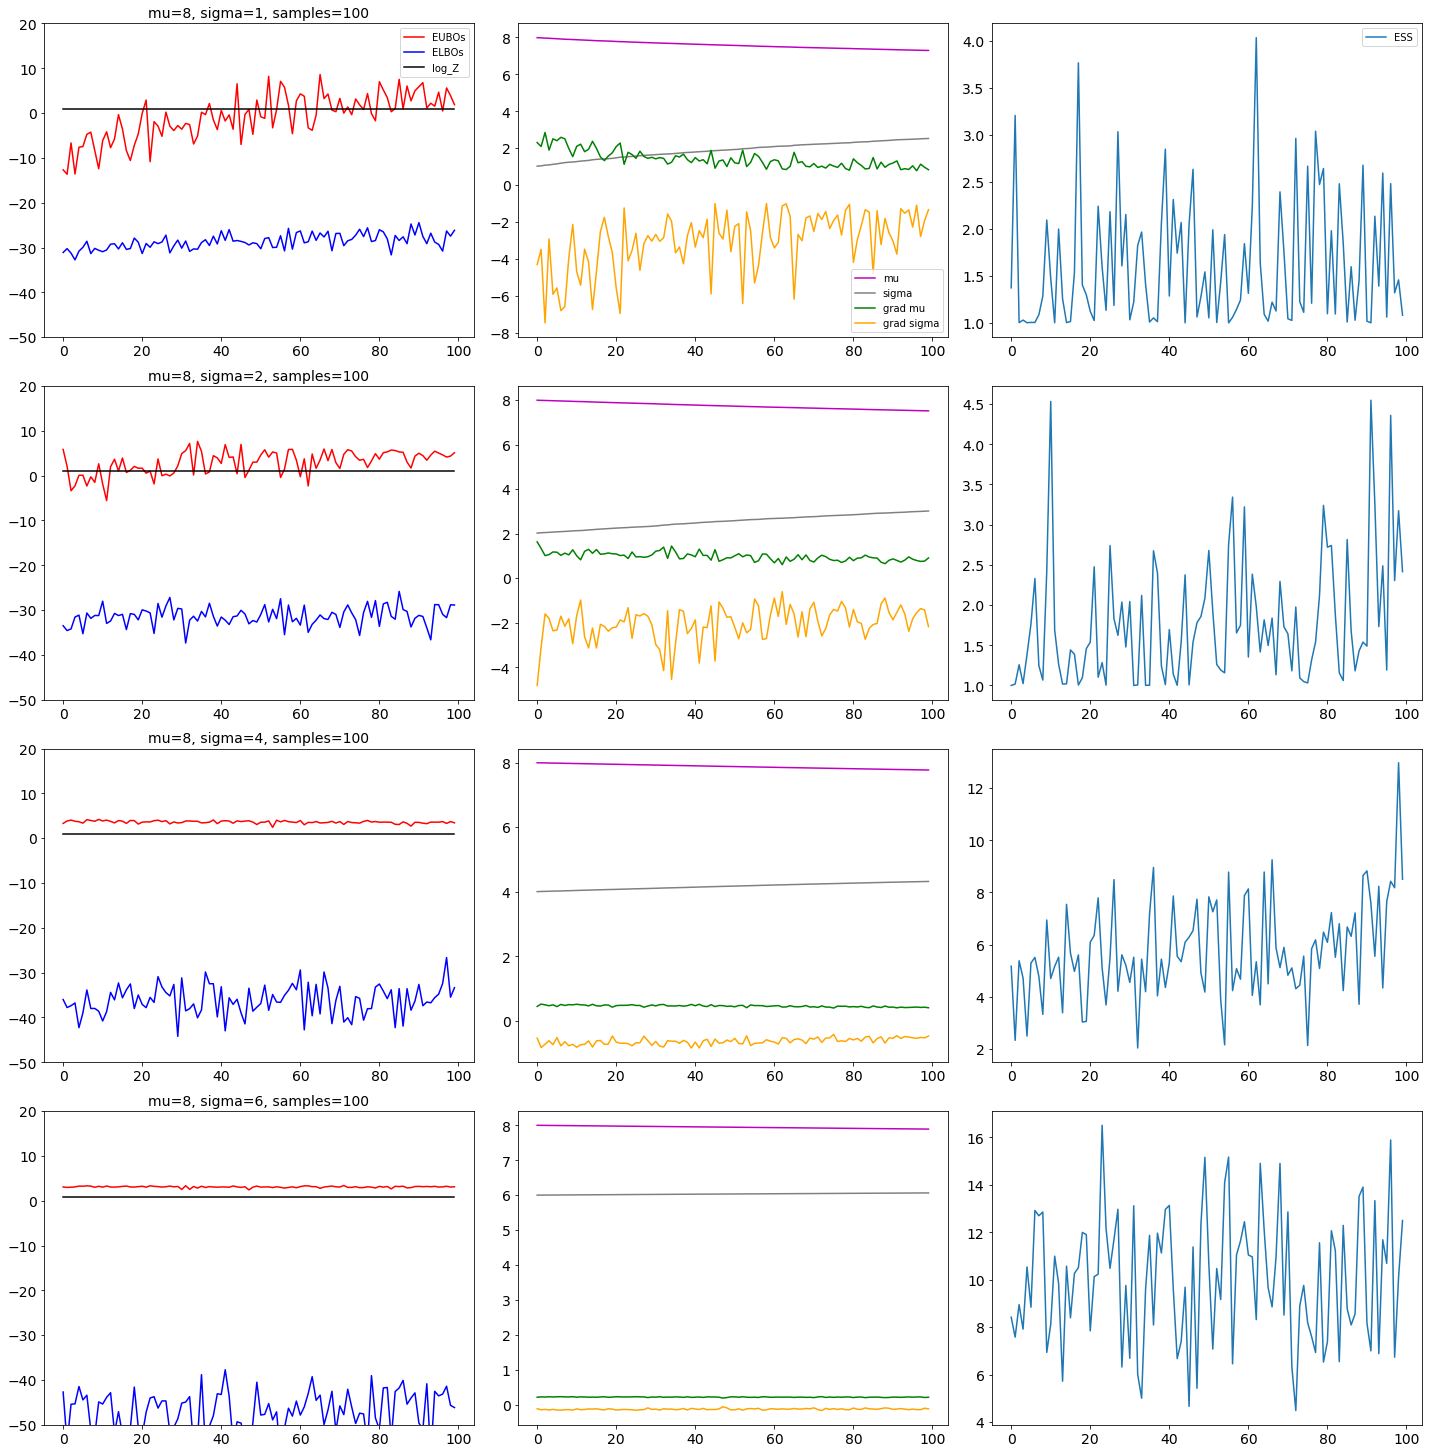

In [6]:
init_mus = np.array([6, 8])
init_sigmas = np.array([1.0, 2.0, 4.0, 6.0])
num_mus = init_mus.shape[0]

for i in range(num_mus):
    EUBOs, ELBOs, Mus, Sigmas, Grad_mus, Grad_sigmas, ESSs = train(init_mus[i], init_sigmas, num_samples, lr)
    plot_results(EUBOs, ELBOs, Mus, Sigmas, Grad_mus, Grad_sigmas, ESSs, init_mus[i], init_sigmas, num_samples)